<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
#For use during testing:
#!pip install leidenalg
#!pip install --index-url https://test.pypi.org/simple/ modisco

!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

## Grab the input data

In [21]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [1]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [2]:
import h5py
from collections import OrderedDict
import numpy as np

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100; #len(fasta_sequences) #100 #since this is just a test run, for speed I am limiting to 100 sequences
#reverse-complement some of the sequences to simulate that
take_rc = (np.random.RandomState(1234).uniform(size=n) > 0.5)
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                            for x,rc in zip(f['contrib_scores'][task][:n], take_rc)]
    task_to_hyp_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                                for x,rc in zip(f['hyp_contrib_scores'][task][:n], take_rc)]

onehot_data = [one_hot_encode_along_channel_axis(seq) if not rc else
               one_hot_encode_along_channel_axis(seq)[::-1,::-1]
               for seq,rc in zip(fasta_sequences[:n], take_rc)]

Double check by plotting

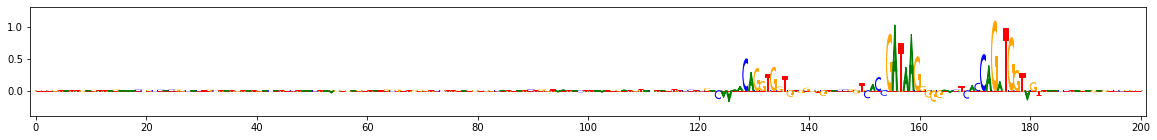

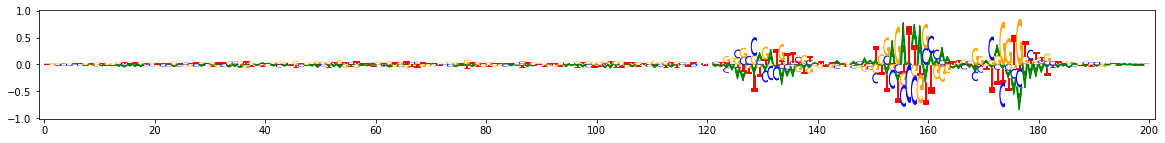

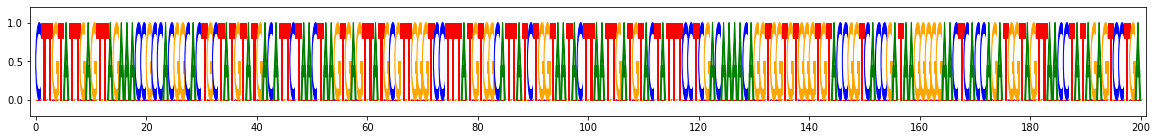

In [24]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. If all three tasks are specified under "task_names", then there will be 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). If only task0 is specified, there will only be two possible metaclusters (+1 and -1). In recent years, we have moved towards running tfmodisco on a single task at a time, which is why the example below just uses task0 (which turns up both the TAL and GATA motifs).

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.1267712
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02277598052151734
Computing threshold
For increasing = True , the minimum IR precision was 0.14668684157935308 occurring at 7.078051567077637e-06 implying a frac_neg of 0.17190270668138782
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4483100377790805 occurring at -1.0013580322265625e-05 implying a frac_neg of 0.812612279502665
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -1.0124836564064026  and  0.898599348962307 with frac passing 0.15951612903225806
Final raw thresholds are -1.0124836564064026  and  0.898599348962307
Final transformed thresholds are -0.8494086021505376  and  0.8400537634408602


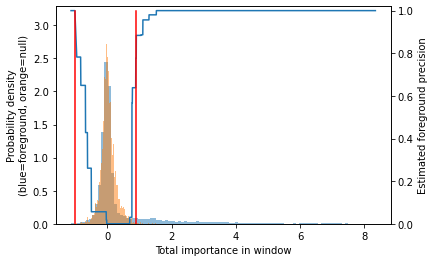

Got 198 coords
After resolving overlaps, got 198 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8399537634408603
MEMORY 0.137695232
198 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [195]
Idx to activities:  {0: '1'}
MEMORY 0.13770752
On metacluster 0
Metacluster size 195
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod zoops -nmotifs 10 -minw 6 -maxw 50 -objfun classic -revcomp -markov_order 0 -oc meme_out/metacluster0
Duration of MEME: 6.4862060546875 seconds
Skipping motif CGCAGGCG as e-value 140000.0 does not meet threshold of 0.05
Skipping motif CCCGCG as e-value 260000.0 does not meet threshold of 0.05
Skipping motif GTAGCCTC as e-value 380000.0 does not meet threshold of 0.05
Skipping motif CGGTGC as e-value 450000.0 does not meet threshold of 0.05
Skipping motif GGCACG as e-v

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 195 out of 195 | elapsed:    4.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 195 out of 195 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.03618001937866211 s
Constructing csr matrix...
csr matrix made in 0.04130697250366211 s
Finished embedding computation in 8.9 s
MEMORY 0.22554624
Starting affinity matrix computations
MEMORY 0.22554624
Batching in slices of size 195


[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.5s finished
100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

Finished affinity matrix computations in 1.53 s
MEMORY 0.22652928
(Round 1) Computed coarse affmat
MEMORY 0.22652928
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.22652928
Launching nearest neighbors affmat calculation job
MEMORY 0.22657024


Parallel runs completed
MEMORY 0.23742464
Job completed in: 0.39 s
MEMORY 0.23742464
Launching nearest neighbors affmat calculation job
MEMORY 0.23742464
Parallel runs completed
MEMORY 0.2381824
Job completed in: 0.4 s
MEMORY 0.2381824
(Round 1) Computed affinity matrix on nearest neighbors in 0.88 s
MEMORY 0.239312896
Filtered down to 192 of 195
(Round 1) Retained 192 rows out of 195 after filtering
MEMORY 0.23953408
(Round 1) Computing density adapted affmat
MEMORY 0.23953408
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 0.242642944
Beginning preprocessing + Leiden
initclusters length: 192
Affmat shape: 192


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Quality: 0.06280247903721797


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 192


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Got 2 clusters after round 1
Counts:
{0: 105, 1: 87}
MEMORY 0.242724864
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.242724864
Aggregating for cluster 0 with 105 seqlets
MEMORY 0.242724864
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 12 seqlets that went over sequence edge during flank expansion
Skipped 5 due to duplicates
Trimming eliminated 0 seqlets out of 87
Skipped 13 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.6s finished


Aggregating for cluster 1 with 87 seqlets
MEMORY 0.242786304
Skipped 8 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 78
Skipped 2 seqlets that went over the sequence edge during flank expansion
Of 150 seqlets, cluster assignments are: Counter({0: 148, -1: 2})
Aggregating for cluster 0 with 148 seqlets
MEMORY 0.242966528
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 147
Skipped 5 seqlets that went over the sequence edge during flank expansion
(Round 2) num seqlets: 150
(Round 2) Computing coarse affmat
MEMORY 0.243154944
Beginning embedding computation
MEMORY 0.243154944


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 131 out of 150 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    2.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.0269620418548584 s
Constructing csr matrix...
csr matrix made in 0.026762008666992188 s
Finished embedding computation in 5.78 s
MEMORY 0.250404864
Starting affinity matrix computations
MEMORY 0.250404864
Batching in slices of size 150


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

Finished affinity matrix computations in 1.53 s
MEMORY 0.250404864
(Round 2) Computed coarse affmat
MEMORY 0.250404864
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.250404864
Launching nearest neighbors affmat calculation job
MEMORY 0.25040896


Parallel runs completed
MEMORY 0.251695104
Job completed in: 0.31 s
MEMORY 0.251645952
Launching nearest neighbors affmat calculation job
MEMORY 0.251645952
Parallel runs completed
MEMORY 0.251645952
Job completed in: 0.32 s
MEMORY 0.251645952
(Round 2) Computed affinity matrix on nearest neighbors in 0.71 s
MEMORY 0.251830272
Not applying filtering for rounds above first round
MEMORY 0.251830272
(Round 2) Computing density adapted affmat
MEMORY 0.251908096
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 0.254275584
Beginning preprocessing + Leiden
initclusters length: 150
Affmat shape: 150


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Quality: 0.06974736827976881


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 150


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Got 2 clusters after round 2
Counts:
{0: 76, 1: 74}
MEMORY 0.254275584
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.254275584
Aggregating for cluster 0 with 76 seqlets
MEMORY 0.25427968
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 75
Aggregating for cluster 1 with 74 seqlets
MEMORY 0.254353408


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.6s finished


Trimming eliminated 0 seqlets out of 74
Got 2 clusters
Splitting into subclusters...
MEMORY 0.254459904
Inspecting pattern 0 for spurious merging
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 0.437607
Beginning preprocessing + Leiden
Affmat shape: 75


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  56 out of  75 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.9s


Quality: 0.1282293842794943
Got subclusters: Counter({0: 23, 2: 19, 1: 19, 3: 14})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.5s finished


Numbers for each pattern pre-subsample: [23, 19, 19, 14]
Numbers after subsampling: [23, 19, 19, 14]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.07074475288391113 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.04960799217224121 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.05293989181518555 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.04917192459106445 s
Cluster sizes
[23 19 19 14]
Cross-contamination matrix:
[[1.   0.71 0.78 0.46]
 [0.58 1.   0.78 0.51]
 [0.66 0.75 1.   0.53]
 [0.54 0.74 0.73 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.95 0.96 0.92]
 [0.95 1.   0.96 0.96]
 [0.96 0.96 1.   0.96]
 [0.92 0.96 0.96 1.  ]]
Collapsing 1 & 2 with crosscontam 0.7532784432286432 and sim 0.9637351390285216
Collapsing 0 & 2 with crosscontam 0.6555905601653176 and sim 0.9615925471577227
Collapsing 1 & 3 with crosscontam 0.5127361339637182 and sim 0.9612429020457233
Collapsing 2 & 3 with crosscontam 0.5331472726136672 and s

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Quality: 0.09726060461571037
Quality: 0.09751444568284004
Got subclusters: Counter({0: 20, 1: 18, 2: 17, 3: 16, 4: 3})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.6s finished


Numbers for each pattern pre-subsample: [20, 18, 17, 16, 3]
Numbers after subsampling: [20, 18, 17, 16, 3]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.08096194267272949 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.06147265434265137 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.06524062156677246 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.06272268295288086 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.024068117141723633 s
Cluster sizes
[20 18 17 16  3]
Cross-contamination matrix:
[[1.   0.55 0.61 0.68 0.08]
 [0.88 1.   0.8  0.79 0.15]
 [0.82 0.64 1.   0.74 0.05]
 [0.86 0.65 0.74 1.   0.14]
 [0.01 0.   0.01 0.05 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.95 0.96 0.97 0.58]
 [0.95 1.   0.96 0.96 0.53]
 [0.96 0.96 1.   0.95 0.53]
 [0.97 0.96 0.95 1.   0.58]
 [0.58 0.53 0.53 0.58 1.  ]]
Collapsing 0 & 3 with crosscontam 0.6840625000000002 and sim 0.9679511390194461
Collapsing 1 & 3 with crosscon

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Iteration 400: error = 0.7029954, gradient norm = 0.0012117 (50 iterations in 0.028s)
[t-SNE] Iteration 450: error = 0.6593162, gradient norm = 0.0009310 (50 iterations in 0.028s)
[t-SNE] Iteration 500: error = 0.6364927, gradient norm = 0.0011049 (50 iterations in 0.018s)
[t-SNE] Iteration 550: error = 0.6072068, gradient norm = 0.0009242 (50 iterations in 0.013s)
[t-SNE] Iteration 600: error = 0.5705084, gradient norm = 0.0010458 (50 iterations in 0.013s)
[t-SNE] Iteration 650: error = 0.5376405, gradient norm = 0.0013518 (50 iterations in 0.016s)
[t-SNE] Iteration 700: error = 0.4726379, gradient norm = 0.0178108 (50 iterations in 0.026s)
[t-SNE] Iteration 750: error = 0.1611193, gradient norm = 0.0148489 (50 iterations in 0.015s)
[t-SNE] Iteration 800: error = 0.1514831, gradient norm = 0.0025185 (50 iterations in 0.013s)
[t-SNE] Iteration 850: error = 0.1515285, gradient norm = 0.0009741 (50 iterations in 0.012s)
[t-SNE] Iteration 900: error = 0.1517072, gradient norm = 0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.9s


Quality: 0.12744002336127436


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  52 out of  71 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  71 out of  71 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 23, 2: 19, 1: 19, 3: 13})
On pattern 1
[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 71 samples in 0.001s...
[t-SNE] Computed neighbors for 71 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 71 / 71
[t-SNE] Mean sigma: 0.477791
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 52.3779373, gradient norm = 0.6054187 (50 iterations in 0.015s)
[t-SNE] Iteration 100: error = 51.1176834, gradient norm = 0.4875111 (50 iterations in 0.013s)
[t-SNE] Iteration 150: error = 48.8018532, gradient norm = 0.4449487 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 52.1530380, gradient norm = 0.5447511 (50 iterations in 0.012s)
[t-SNE] Iteration 250: error = 50.9462967, gradient norm = 0.4620174 (50 iterations in 0.018s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.946297
[t-SNE] Iteration 300: error = 0.7157012, gradient norm = 0.0023502 (50 iterations in 0.013s)
[t-SN

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.9s


Quality: 0.08528066364798892
Quality: 0.09020102234331018
Got subclusters: Counter({0: 20, 1: 18, 2: 17, 3: 16})


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.5s finished


In [3]:
import h5py
import numpy as np
%matplotlib inline
import modisco

#Uncomment to refresh modules for when tweaking code during development:
from importlib import reload
reload(modisco.util)
reload(modisco.pattern_filterer)
reload(modisco.aggregator)
reload(modisco.core)
reload(modisco.affinitymat.transformers)
reload(modisco.affinitymat.core)
reload(modisco.affinitymat)
reload(modisco.cluster.core)
reload(modisco.cluster)
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
reload(modisco)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                            meme_command="meme", base_outdir="meme_out",            
                            max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        final_min_cluster_size=60,
                        n_cores=10)
                )(
                 task_names=["task0"],#, "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores=null_per_pos_scores)

## Save Results

In [4]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


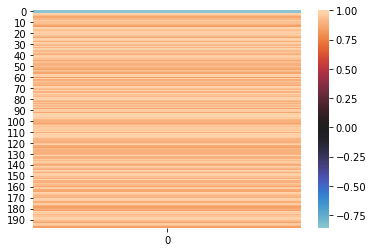

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 74
Task 0 hypothetical scores:


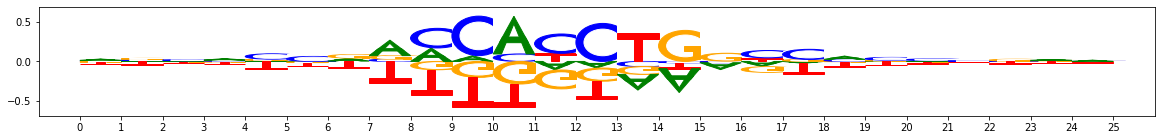

Task 0 actual importance scores:


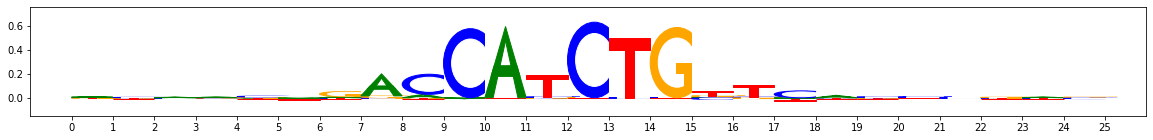

onehot, fwd and rev:


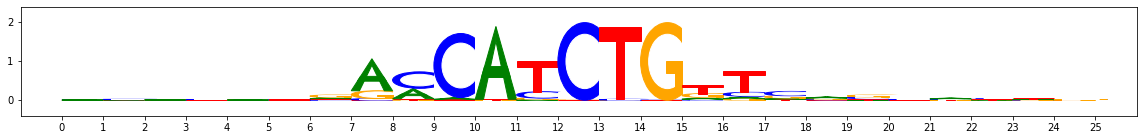

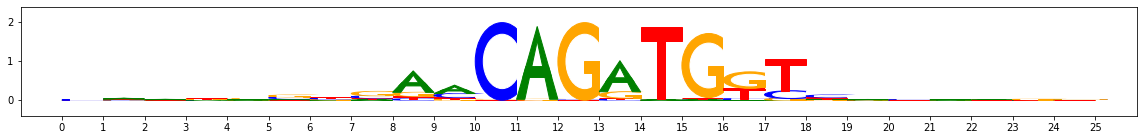

PLOTTING SUBCLUSTERS


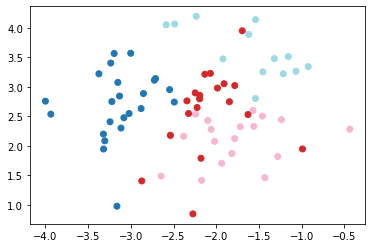

subcluster_0 size 23


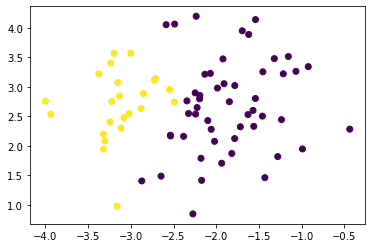

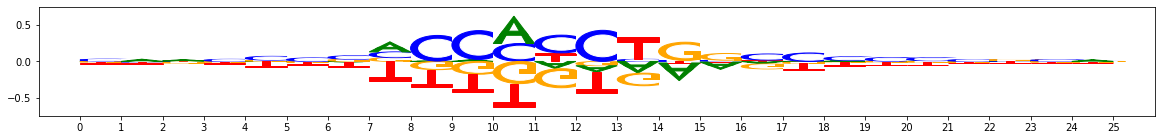

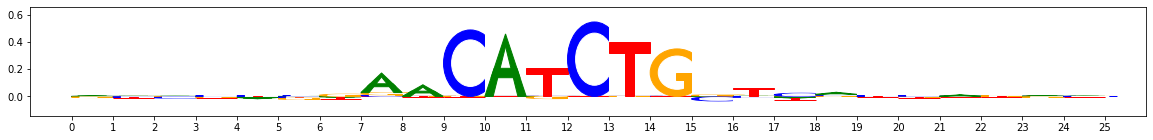

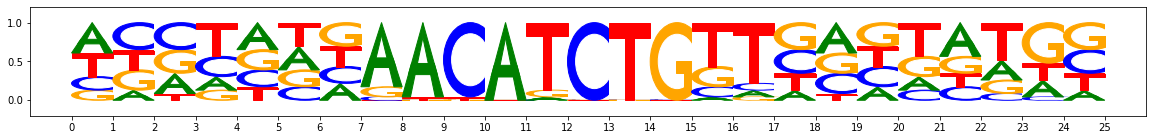

subcluster_2 size 19


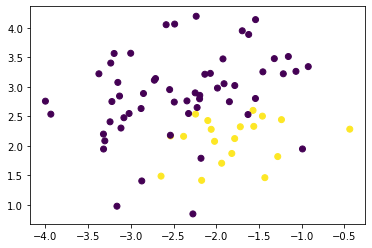

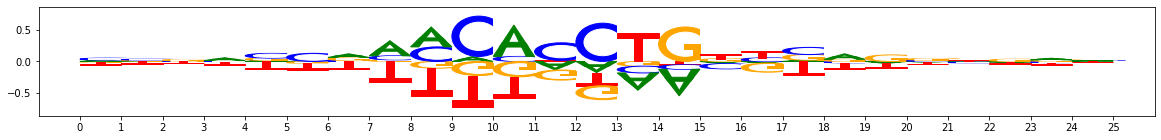

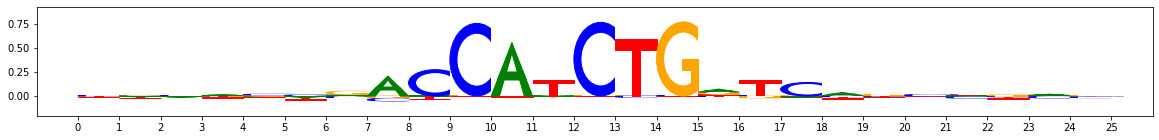

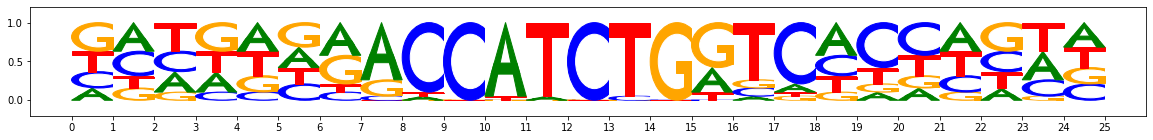

subcluster_1 size 19


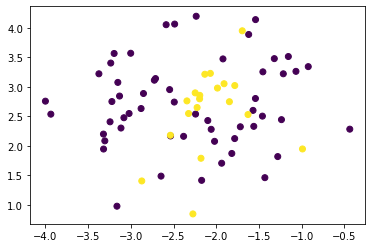

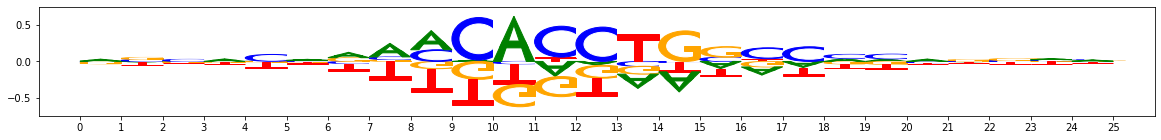

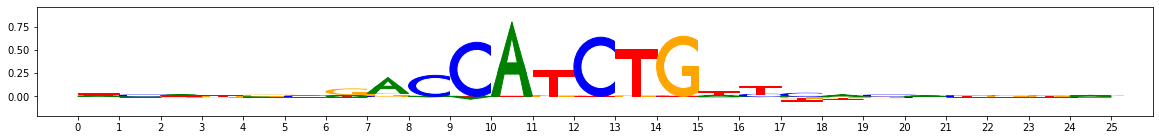

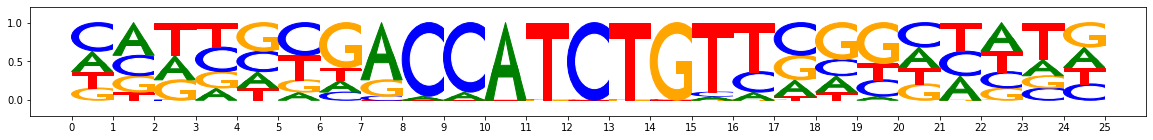

subcluster_3 size 13


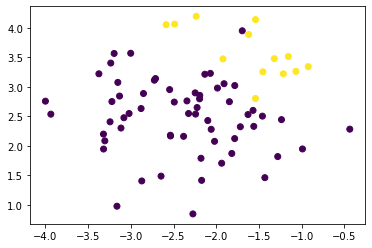

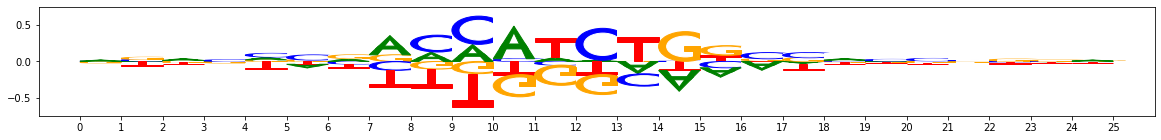

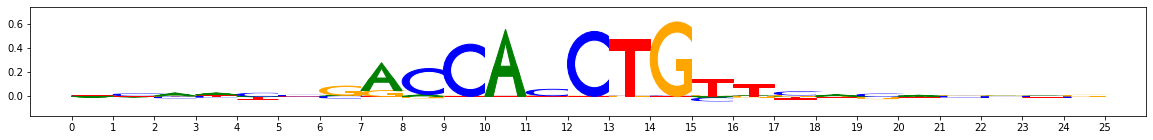

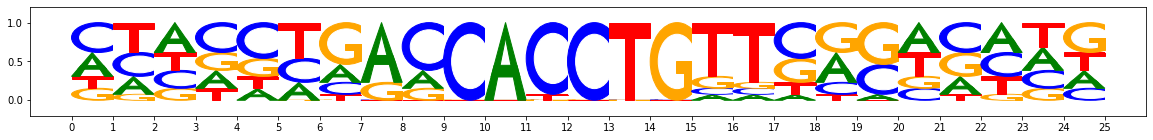

metacluster_0 pattern_1
total seqlets: 71
Task 0 hypothetical scores:


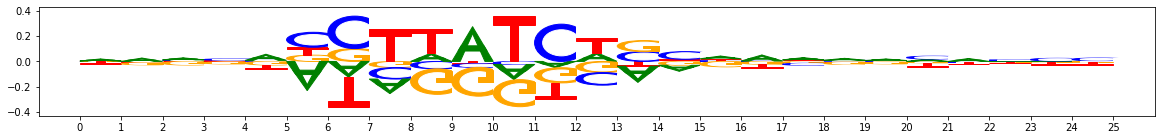

Task 0 actual importance scores:


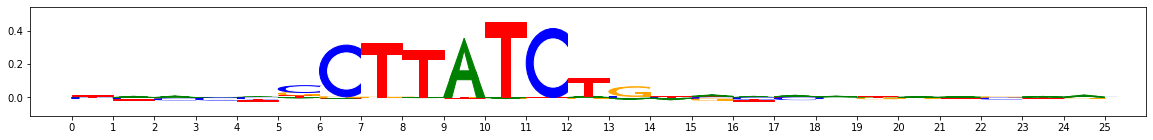

onehot, fwd and rev:


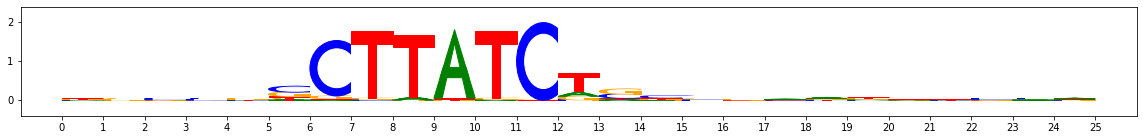

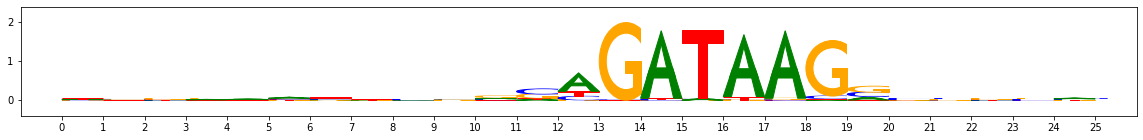

PLOTTING SUBCLUSTERS


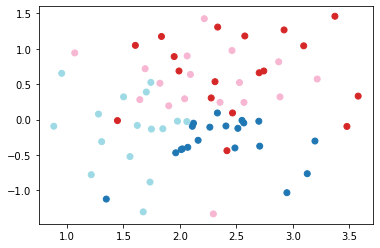

subcluster_0 size 20


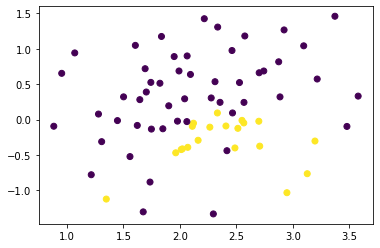

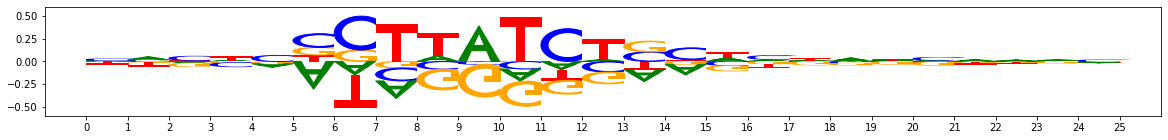

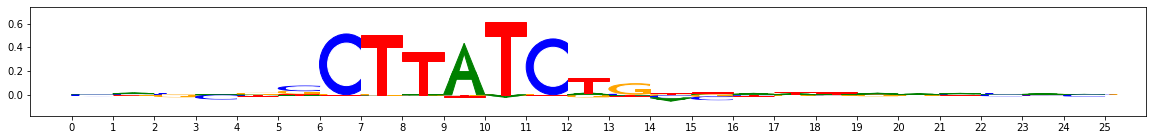

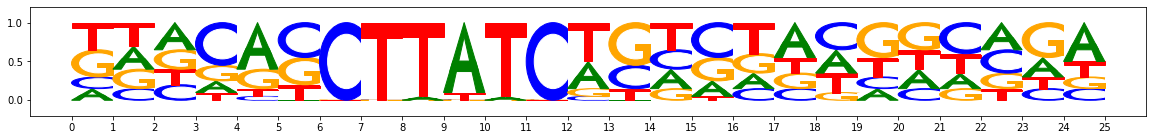

subcluster_1 size 18


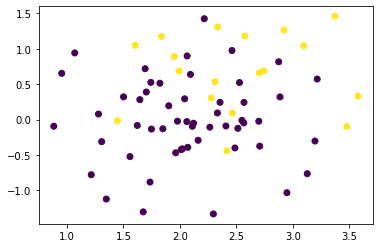

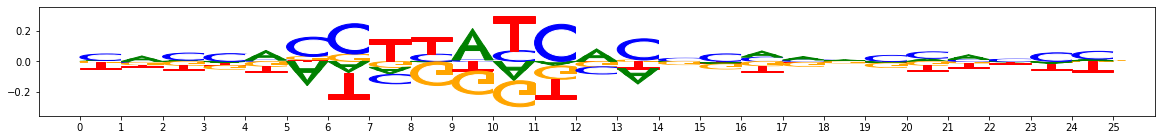

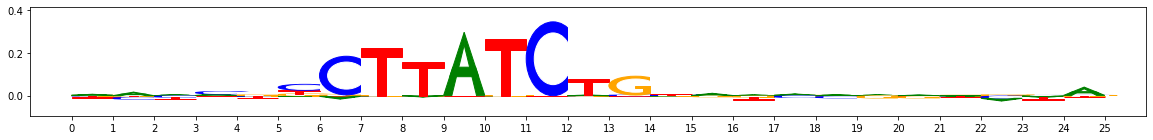

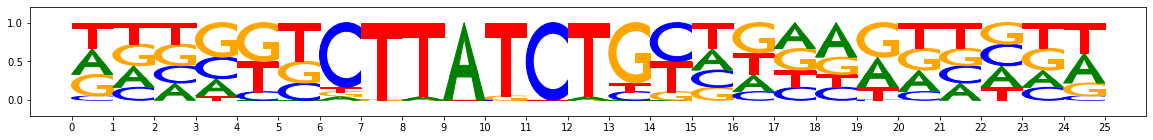

subcluster_2 size 17


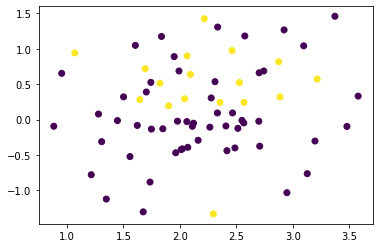

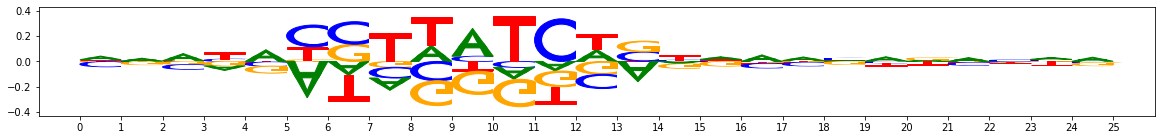

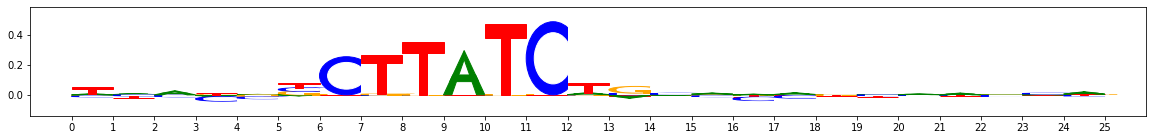

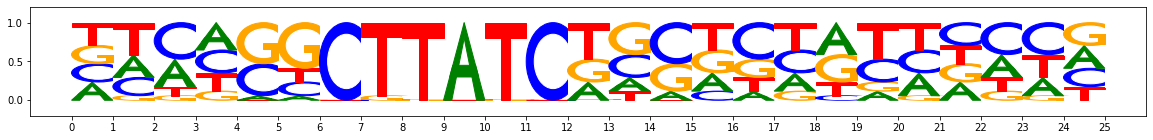

subcluster_3 size 16


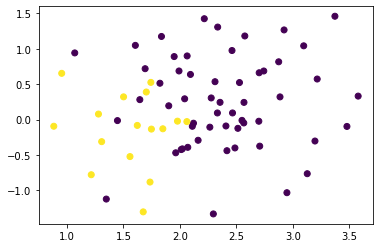

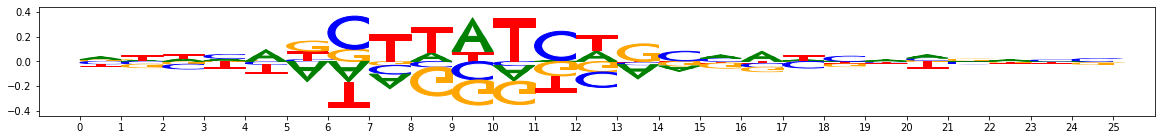

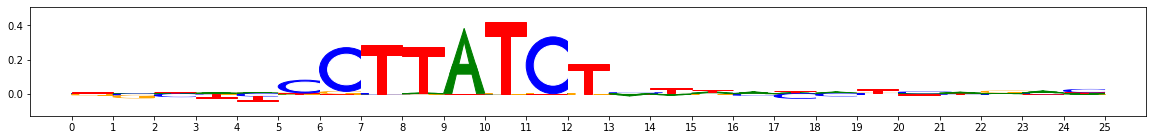

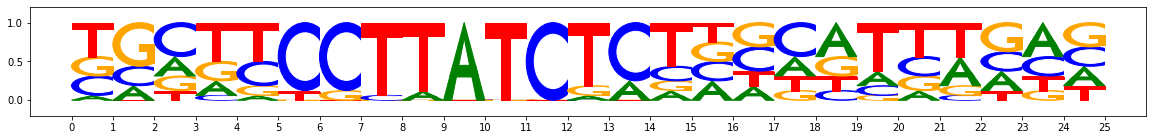

In [5]:
from collections import Counter
import numpy as np

from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.mean(onehot_data, axis=(0,1))

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        #Plot the subclustering too, if available
        if ("subclusters" in pattern):
            print("PLOTTING SUBCLUSTERS")
            subclusters = np.array(pattern["subclusters"])
            twod_embedding = np.array(pattern["twod_embedding"])
            plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
            plt.show()
            for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
                subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
                print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
                subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
                plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
                plt.show()
                viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
                viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
                viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [6]:
import h5py
import numpy as np
from importlib import reload
import modisco
reload(modisco.util)
reload(modisco.core)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

#If loading from a file for which subclusters haven't been computed (e.g. a file produced by an
# earlier version of modisco), you can compute the subclusters by
# following this template:
#patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
#            .seqlets_to_patterns_result.patterns)
#for pattern in patterns:
#    pattern.compute_subclusters_and_embedding(
#                 pattern_comparison_settings=modisco.affinitymat.core.PatternComparisonSettings(                         
#                    track_names=["task0_hypothetical_contribs", "task0_contrib_scores"],                      
#                    track_transformer=modisco.affinitymat.L1Normalizer(),
#                    min_overlap=None), #min_overlap argument is irrelevant here    
#                 perplexity=30, n_jobs=4, verbose=True)

## Do hit scoring
The hit scoring strategy is still in development. For the previous hit scoring strategy, see the version at https://github.com/kundajelab/tfmodisco/blob/v0.5.13.2/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA_hitscoring.ipynb

Getting trimmed patterns, subclustering them
Trimming the patterns to the target length
Apply subclustering


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.6s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 74 samples in 0.001s...
[t-SNE] Computed neighbors for 74 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 0.436397
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 51.8853607, gradient norm = 0.4637910 (50 iterations in 0.030s)
[t-SNE] Iteration 100: error = 50.1360016, gradient norm = 0.4128502 (50 iterations in 0.013s)
[t-SNE] Iteration 150: error = 52.9414558, gradient norm = 0.5017180 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 52.0900345, gradient norm = 0.5453429 (50 iterations in 0.013s)
[t-SNE] Iteration 250: error = 52.8413086, gradient norm = 0.4979126 (50 iterations in 0.013s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.841309
[t-SNE] Iteration 300: error = 0.8926135, gradient norm = 0.0027051 (50 iterations in 0.012s)
[t-SNE] Iteration 350: error = 0.7730397, gradient norm = 0.0013956 (50 i

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s


Quality: 0.12744002336127436


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  71 out of  71 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 23, 2: 19, 1: 19, 3: 13})
[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 71 samples in 0.001s...
[t-SNE] Computed neighbors for 71 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 71 / 71
[t-SNE] Mean sigma: 0.477791
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 52.3779373, gradient norm = 0.6054187 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 51.1176834, gradient norm = 0.4875111 (50 iterations in 0.013s)
[t-SNE] Iteration 150: error = 48.8018532, gradient norm = 0.4449487 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 52.1530380, gradient norm = 0.5447511 (50 iterations in 0.013s)
[t-SNE] Iteration 250: error = 50.9462967, gradient norm = 0.4620174 (50 iterations in 0.012s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.946297
[t-SNE] Iteration 300: error = 0.7157012, gradient norm = 0.0023502 (50 iterations in 0.012s)
[t-SNE] Iteration 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s


Quality: 0.08528066364798892
Quality: 0.09020102234331018


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Got subclusters: Counter({0: 20, 1: 18, 2: 17, 3: 16})
Preparing seqlet scorer
Pattern length (and hence target seqlet size) is 25
Prepare seqlet scorer
Computing coarse-grained embeddings


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 138 out of 145 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 138 out of 145 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.025427818298339844 s
Constructing csr matrix...
csr matrix made in 0.02558588981628418 s
Computing coarse top k nn via cosine sim
Batching in slices of size 145


[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    0.3s finished
100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

Computing fine-grained sim for top k
Launching nearest neighbors affmat calculation job
MEMORY 0.289693696


Parallel runs completed
MEMORY 0.293019648
Job completed in: 0.58 s
MEMORY 0.293019648
Launching nearest neighbors affmat calculation job
MEMORY 0.293019648
Parallel runs completed
MEMORY 0.293019648
Job completed in: 0.53 s
MEMORY 0.293019648
Accuracy: 1.0
Accuracy: 1.0
Mapping affinity to distmat
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
Computing density-adapted nn affmat
Beginning preprocessing + Leiden
initclusters length: 145
Affmat shape: 145


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s


Quality: 0.07074677094039375
Quality: 0.07075436638463567
Number of reclustered idxs: 2
{(1, 1), (0, 0)}
Preparing modularity scorer
Accuracy: 1.0
Fitting - on window size 7
peak(mu)= -0.004282484851777554
Computing window sums
Done computing window sums


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.7s finished


For increasing = True , the minimum IR precision was 0.40826467476677464 occurring at 1.475214958190918e-06 implying a frac_neg of 0.6899447394083867
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.0 occurring at -1.3776182227951544e-05 implying a frac_neg of 1.00000010000001e-07
To be conservative, adjusted frac neg is 0.95


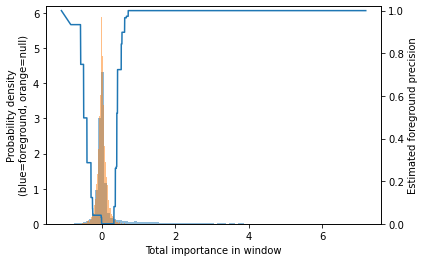

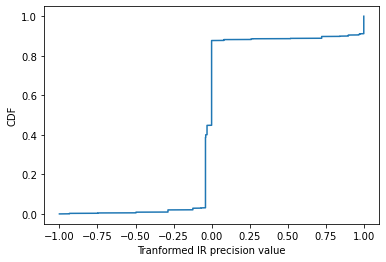

Thresholds from null dist were -0.8  and  0.8 with frac passing 0.10525
Got 353 coords


In [7]:
import modisco
import modisco.util
reload(modisco.util)
reload(modisco.cluster.core)
reload(modisco.coordproducers)
from modisco.visualization import viz_sequence
reload(modisco.aggregator)
from modisco import hit_scoring
reload(modisco.hit_scoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.hit_scoring.densityadapted_hitscoring)
reload(densityadapted_hitscoring)
reload(modisco.cluster.core)

orig_patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
                .seqlets_to_patterns_result.patterns)

#The hit-scorer works in two stages:
# (1) Identifying regions of high importance ("seqlets")
# (2) Mapping those seqlets to patterns (motifs)
#(The two stages are independent of each other)

#instantiate the hit_scorer by providing the patterns
# that identified seqlets will be mapped to. The patterns
# will be trimmed to target_seqlet_size
hit_scorer = densityadapted_hitscoring.MakeHitScorer(
    patterns=orig_patterns,
    target_seqlet_size=25,
    bg_freq=np.mean(onehot_data, axis=(0,1)),
    task_names_and_signs=[("task0",1)],
    n_cores=4)

#set the method used to identify coordinates of high importance ("seqlets")
#You have to provide a contribution score track as this will be used
# to calibrate the threshold used for seqlet identification. You
# can also optionally provide an empirical null distribution track via
# the 'null_track' argument, similar to when tf-modisco is first run.
hit_scorer.set_coordproducer(contrib_scores=task_to_scores,
                             core_sliding_window_size=7,
                             target_fdr=0.2,
                             min_passing_windows_frac=0.03,
                             max_passing_windows_frac=0.2,
                             separate_pos_neg_thresholds=False,                             
                             max_seqlets_total=np.inf)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.01303410530090332 s
Batching in slices of size 74


[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.2s finished
100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

Launching nearest neighbors affmat calculation job
MEMORY 0.295530496


Parallel runs completed
MEMORY 0.29558784
Job completed in: 0.32 s
MEMORY 0.29558784
Launching nearest neighbors affmat calculation job
MEMORY 0.29558784
Parallel runs completed
MEMORY 0.29558784
Job completed in: 0.3 s
MEMORY 0.29558784
Removed 0 duplicates
Pattern idx: 0
Num matches: 74 of 74
Original pattern:


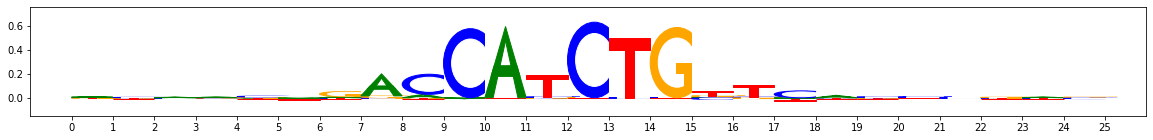

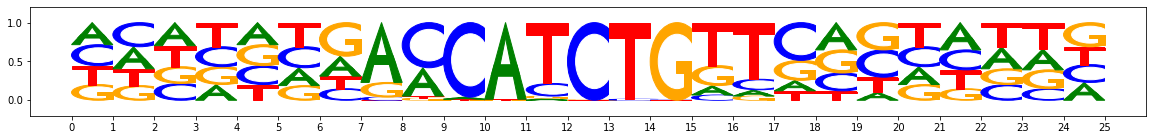

From assigned seqlets:


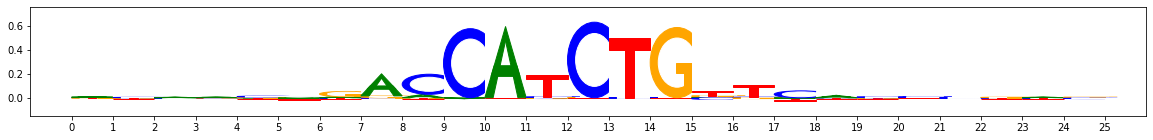

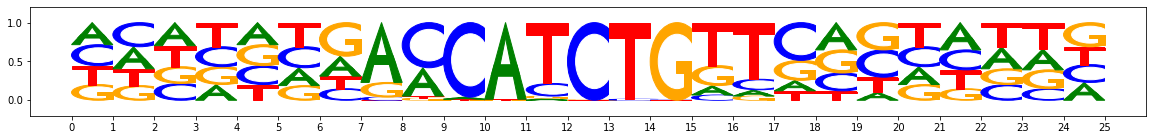

In [8]:
#Test the seqlet scorer. Let's see what happens to the assignment of seqlets
# from a particular pattern

seqletmatches_pattern0,patternidx_to_matches_forpattern0seqlets,_ = hit_scorer.seqlet_scorer(
    hit_scorer.trimmed_subclustered_patterns[0].seqlets)

for patternidx,pattern in enumerate(hit_scorer.seqlet_scorer.class_patterns):
    matches = patternidx_to_matches_forpattern0seqlets[patternidx]
    if (len(matches) > 0):
        print("Pattern idx:",patternidx)
        print("Num matches:",len(matches),"of",len(seqletmatches_pattern0))
        print("Original pattern:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(pattern["sequence"].fwd)
        print("From assigned seqlets:")
        avg_contrib = np.mean([(task_to_scores["task0"][match.exampleidx][match.start:match.end][::-1,::-1]
                                if match.is_revcomp
                                else task_to_scores["task0"][match.exampleidx][match.start:match.end])
                               for match in matches], axis=0)
        viz_sequence.plot_weights(avg_contrib)
        onehot_seq = np.mean([(onehot_data[match.exampleidx][match.start:match.end][::-1,::-1]
                               if match.is_revcomp
                                else onehot_data[match.exampleidx][match.start:match.end])
                               for match in matches], axis=0)
        viz_sequence.plot_weights(onehot_seq)

In [9]:
#Now that the hit-scorer is configured, you can call it on some data to
# get the motif hit calls.
#Note that the values provided to contrib_scores below DO NOT have to be
# the same as the values provided to set_coordproducer above.
(exampleidx_to_matches, patternidx_to_matches) = hit_scorer(
           contrib_scores=task_to_scores,
           hypothetical_contribs=task_to_hyp_scores,
           one_hot=onehot_data,
           hits_to_return_per_seqlet=1)

Got 353 coords


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 346 out of 353 | elapsed:    8.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 353 out of 353 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.06413888931274414 s
Batching in slices of size 353


[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed:    0.7s finished
100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

Launching nearest neighbors affmat calculation job
MEMORY 0.321990656


Parallel runs completed
MEMORY 0.32278528
Job completed in: 1.22 s
MEMORY 0.32278528
Launching nearest neighbors affmat calculation job
MEMORY 0.32278528
Parallel runs completed
MEMORY 0.323551232
Job completed in: 1.21 s
MEMORY 0.323551232
Removed 133 duplicates


MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.7906116, exampleidx=0, start=118, end=143, is_revcomp=True, seqlet_orig_start=115, seqlet_orig_end=140, seqlet_orig_revcomp=False, aggregate_sim=0.4705740160557683, mod_delta=0.0010923598150923974, mod_precision=1.0, mod_percentile=0.8513513513513513, fann_perclasssum_perc=0.28378378378378377, fann_perclassavg_perc=0.28378378378378377)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=4.300193, exampleidx=0, start=141, end=166, is_revcomp=True, seqlet_orig_start=139, seqlet_orig_end=164, seqlet_orig_revcomp=False, aggregate_sim=0.5796655341500428, mod_delta=0.001171412331230773, mod_precision=1.0, mod_percentile=0.9154929577464789, fann_perclasssum_perc=0.8450704225352113, fann_perclassavg_perc=0.8450704225352113)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=4.301201, exampleidx=0, start=161, end=186, is_revcomp=True, seqlet_orig_start=165, seqlet_orig_end

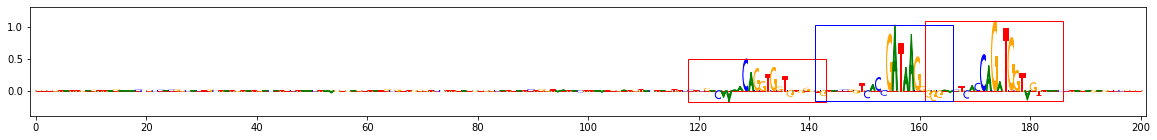

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.94397223, exampleidx=1, start=67, end=92, is_revcomp=False, seqlet_orig_start=62, seqlet_orig_end=87, seqlet_orig_revcomp=False, aggregate_sim=0.40282458262641285, mod_delta=0.0006184846117355597, mod_precision=0.9967991115634891, mod_percentile=0.0, fann_perclasssum_perc=0.3380281690140845, fann_perclassavg_perc=0.3380281690140845)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.8151858, exampleidx=1, start=91, end=116, is_revcomp=False, seqlet_orig_start=88, seqlet_orig_end=113, seqlet_orig_revcomp=False, aggregate_sim=0.35249292909132307, mod_delta=0.00040055439614270806, mod_precision=0.6969626251043824, mod_percentile=0.0, fann_perclasssum_perc=0.15492957746478875, fann_perclassavg_perc=0.15492957746478875)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.6977035, exampleidx=1, start=158, end=183, is_revcomp=False, seqlet_orig_start=154, seqlet_orig

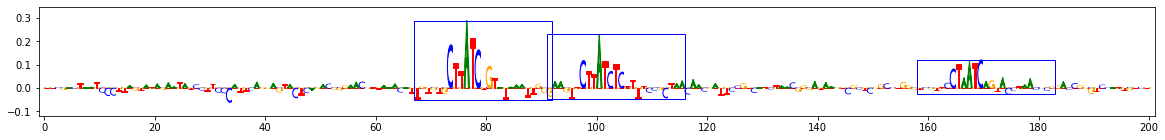

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=0.67624635, exampleidx=2, start=5, end=30, is_revcomp=True, seqlet_orig_start=2, seqlet_orig_end=27, seqlet_orig_revcomp=False, aggregate_sim=0.38896063635043443, mod_delta=0.0004047079813088916, mod_precision=1.0, mod_percentile=0.027027027027026973, fann_perclasssum_perc=0.05405405405405406, fann_perclassavg_perc=0.05405405405405406)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.9630653, exampleidx=2, start=62, end=87, is_revcomp=True, seqlet_orig_start=59, seqlet_orig_end=84, seqlet_orig_revcomp=False, aggregate_sim=0.5632368382969452, mod_delta=0.0007865370884003325, mod_precision=1.0, mod_percentile=0.1216216216216216, fann_perclasssum_perc=0.7432432432432432, fann_perclassavg_perc=0.7432432432432432)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.8151278, exampleidx=2, start=144, end=169, is_revcomp=True, seqlet_orig_start=141, seqlet_orig_end=16

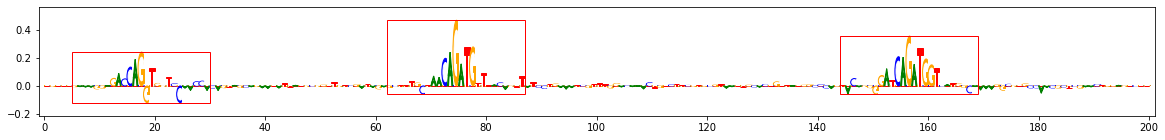

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.3442076, exampleidx=3, start=24, end=49, is_revcomp=False, seqlet_orig_start=23, seqlet_orig_end=48, seqlet_orig_revcomp=False, aggregate_sim=0.29745166797427036, mod_delta=0.00038080760735969676, mod_precision=0.669794259527166, mod_percentile=0.0, fann_perclasssum_perc=0.028169014084507005, fann_perclassavg_perc=0.028169014084507005)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=4.1543303, exampleidx=3, start=68, end=93, is_revcomp=False, seqlet_orig_start=68, seqlet_orig_end=93, seqlet_orig_revcomp=False, aggregate_sim=0.5732397182972754, mod_delta=0.001121301568974573, mod_precision=1.0, mod_percentile=0.8028169014084507, fann_perclasssum_perc=0.7887323943661972, fann_perclassavg_perc=0.7887323943661972)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=2.578879, exampleidx=3, start=96, end=121, is_revcomp=False, seqlet_orig_start=99, seqlet_orig_end=12

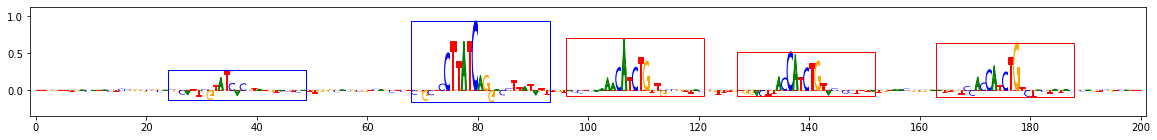

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=-0.55773544, exampleidx=4, start=107, end=132, is_revcomp=False, seqlet_orig_start=106, seqlet_orig_end=131, seqlet_orig_revcomp=False, aggregate_sim=0.0881952394306624, mod_delta=0.00010767619775837577, mod_precision=1.0, mod_percentile=0.013513513513513487, fann_perclasssum_perc=0.0, fann_perclassavg_perc=0.0)


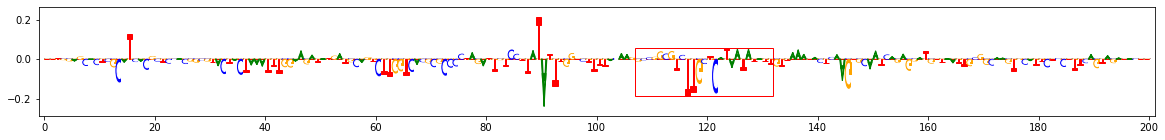

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=-0.87229973, exampleidx=5, start=97, end=122, is_revcomp=True, seqlet_orig_start=97, seqlet_orig_end=122, seqlet_orig_revcomp=False, aggregate_sim=0.10254781329288279, mod_delta=0.0001451549146385912, mod_precision=1.0, mod_percentile=0.027027027027026973, fann_perclasssum_perc=0.0, fann_perclassavg_perc=0.0)


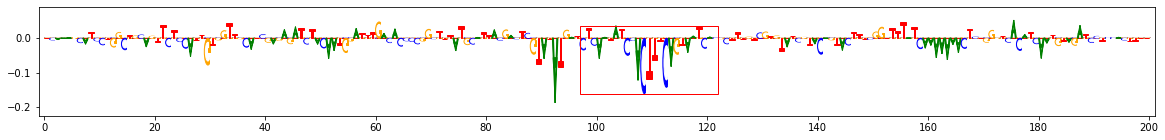

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=-1.0824697, exampleidx=6, start=100, end=125, is_revcomp=False, seqlet_orig_start=98, seqlet_orig_end=123, seqlet_orig_revcomp=False, aggregate_sim=0.05363245939802394, mod_delta=3.106621675496874e-05, mod_precision=0.1886070618594582, mod_percentile=0.0, fann_perclasssum_perc=0.0, fann_perclassavg_perc=0.0)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.27930075, exampleidx=6, start=161, end=186, is_revcomp=True, seqlet_orig_start=162, seqlet_orig_end=187, seqlet_orig_revcomp=False, aggregate_sim=0.2557005362021287, mod_delta=0.00033401119489796186, mod_precision=0.6054100168316432, mod_percentile=0.0, fann_perclasssum_perc=0.014084507042253502, fann_perclassavg_perc=0.014084507042253502)


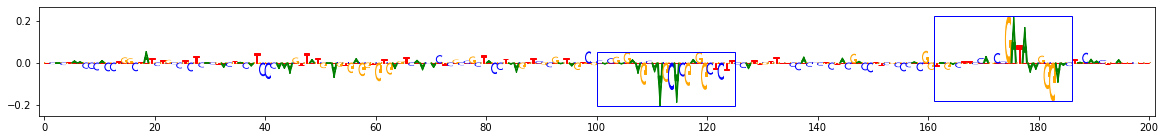

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.76344466, exampleidx=8, start=27, end=52, is_revcomp=False, seqlet_orig_start=23, seqlet_orig_end=48, seqlet_orig_revcomp=False, aggregate_sim=0.4133884594365807, mod_delta=0.0008442688802612463, mod_precision=1.0, mod_percentile=0.18309859154929575, fann_perclasssum_perc=0.3802816901408451, fann_perclassavg_perc=0.3802816901408451)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=1.1459016, exampleidx=8, start=89, end=114, is_revcomp=False, seqlet_orig_start=91, seqlet_orig_end=116, seqlet_orig_revcomp=False, aggregate_sim=0.37851583672716815, mod_delta=0.0007290902837606469, mod_precision=1.0, mod_percentile=0.09859154929577463, fann_perclasssum_perc=0.23943661971830987, fann_perclassavg_perc=0.23943661971830987)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.8965665, exampleidx=8, start=135, end=160, is_revcomp=False, seqlet_orig_start=131, seqlet_orig

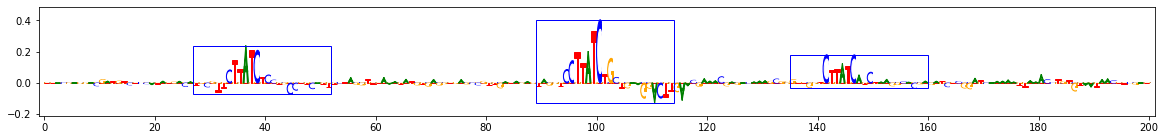

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=2.8050842, exampleidx=9, start=27, end=52, is_revcomp=False, seqlet_orig_start=20, seqlet_orig_end=45, seqlet_orig_revcomp=False, aggregate_sim=0.5863339465572242, mod_delta=0.0008042436609767339, mod_precision=1.0, mod_percentile=0.12676056338028174, fann_perclasssum_perc=0.971830985915493, fann_perclassavg_perc=0.971830985915493)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=7.723337, exampleidx=9, start=80, end=105, is_revcomp=False, seqlet_orig_start=82, seqlet_orig_end=107, seqlet_orig_revcomp=False, aggregate_sim=0.5711587003520513, mod_delta=0.0011479338998143726, mod_precision=1.0, mod_percentile=0.9594594594594594, fann_perclasssum_perc=0.6486486486486487, fann_perclassavg_perc=0.6486486486486487)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=2.5078971, exampleidx=9, start=165, end=190, is_revcomp=False, seqlet_orig_start=166, seqlet_orig_end=191

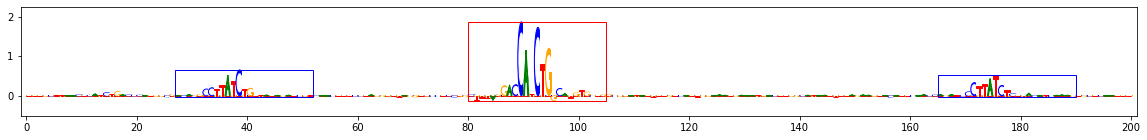

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=3.484661, exampleidx=10, start=124, end=149, is_revcomp=True, seqlet_orig_start=123, seqlet_orig_end=148, seqlet_orig_revcomp=False, aggregate_sim=0.4967333735636006, mod_delta=0.0010406553796805697, mod_precision=1.0, mod_percentile=0.6056338028169015, fann_perclasssum_perc=0.5352112676056338, fann_perclassavg_perc=0.5352112676056338)


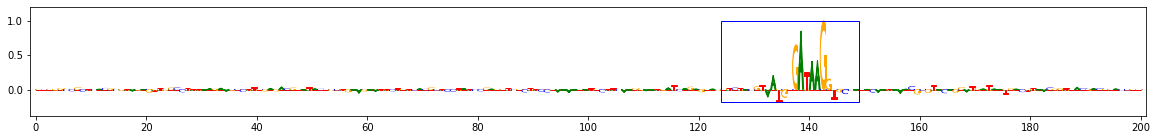

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=6.710516, exampleidx=11, start=46, end=71, is_revcomp=False, seqlet_orig_start=46, seqlet_orig_end=71, seqlet_orig_revcomp=False, aggregate_sim=0.6060914577380493, mod_delta=0.0008936894141498633, mod_precision=1.0, mod_percentile=0.28378378378378377, fann_perclasssum_perc=0.9054054054054054, fann_perclassavg_perc=0.9054054054054054)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=3.0266817, exampleidx=11, start=98, end=123, is_revcomp=False, seqlet_orig_start=99, seqlet_orig_end=124, seqlet_orig_revcomp=False, aggregate_sim=0.45003518849482754, mod_delta=0.0006960972749583847, mod_precision=1.0, mod_percentile=0.07042253521126762, fann_perclasssum_perc=0.3661971830985915, fann_perclassavg_perc=0.3661971830985915)


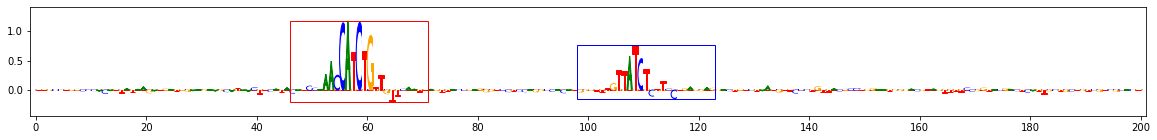

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=7.414847, exampleidx=12, start=93, end=118, is_revcomp=False, seqlet_orig_start=93, seqlet_orig_end=118, seqlet_orig_revcomp=False, aggregate_sim=0.5839292043211459, mod_delta=0.00102236895278168, mod_precision=1.0, mod_percentile=0.6486486486486487, fann_perclasssum_perc=0.7567567567567568, fann_perclassavg_perc=0.7567567567567568)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=2.8317103, exampleidx=12, start=131, end=156, is_revcomp=False, seqlet_orig_start=132, seqlet_orig_end=157, seqlet_orig_revcomp=False, aggregate_sim=0.5831269348009578, mod_delta=0.0009488529743201706, mod_precision=1.0, mod_percentile=0.3802816901408451, fann_perclasssum_perc=0.971830985915493, fann_perclassavg_perc=0.971830985915493)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=2.1315565, exampleidx=12, start=176, end=201, is_revcomp=False, seqlet_orig_start=169, seqlet_orig_end

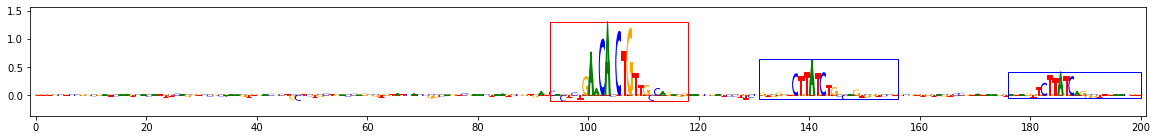

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=6.584242, exampleidx=13, start=5, end=30, is_revcomp=False, seqlet_orig_start=0, seqlet_orig_end=25, seqlet_orig_revcomp=False, aggregate_sim=0.520233718840996, mod_delta=0.0005737437861136774, mod_precision=1.0, mod_percentile=0.027027027027026973, fann_perclasssum_perc=0.3783783783783784, fann_perclassavg_perc=0.3783783783783784)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=3.5050392, exampleidx=13, start=178, end=203, is_revcomp=False, seqlet_orig_start=169, seqlet_orig_end=194, seqlet_orig_revcomp=False, aggregate_sim=0.5238112449397226, mod_delta=0.0006548172803910075, mod_precision=1.0, mod_percentile=0.04225352112676062, fann_perclasssum_perc=0.5633802816901409, fann_perclassavg_perc=0.5633802816901409)


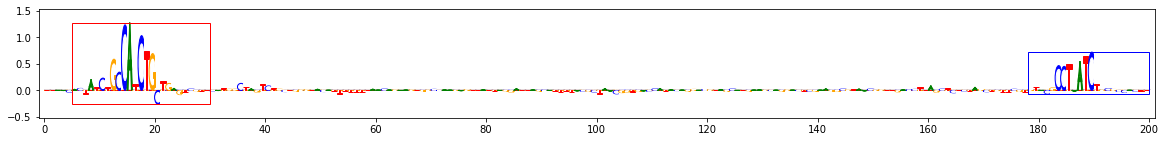

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.53504115, exampleidx=14, start=38, end=63, is_revcomp=True, seqlet_orig_start=41, seqlet_orig_end=66, seqlet_orig_revcomp=False, aggregate_sim=0.35683954024924996, mod_delta=0.0010503672708661342, mod_precision=1.0, mod_percentile=0.6338028169014085, fann_perclasssum_perc=0.08450704225352113, fann_perclassavg_perc=0.08450704225352113)


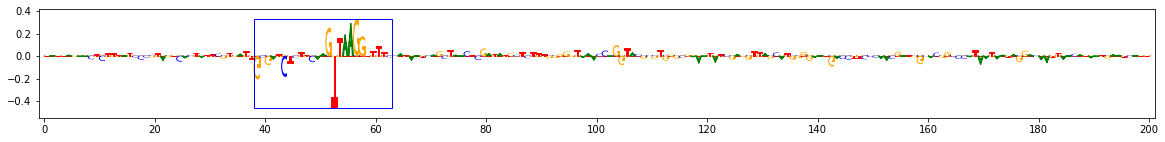

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=3.833371, exampleidx=15, start=114, end=139, is_revcomp=False, seqlet_orig_start=114, seqlet_orig_end=139, seqlet_orig_revcomp=False, aggregate_sim=0.5484010860609431, mod_delta=0.0011494841073981356, mod_precision=1.0, mod_percentile=0.8732394366197183, fann_perclasssum_perc=0.8309859154929577, fann_perclassavg_perc=0.8309859154929577)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=7.592316, exampleidx=15, start=166, end=191, is_revcomp=False, seqlet_orig_start=160, seqlet_orig_end=185, seqlet_orig_revcomp=False, aggregate_sim=0.625994470011355, mod_delta=0.0005947220149052704, mod_precision=1.0, mod_percentile=0.027027027027026973, fann_perclasssum_perc=0.9189189189189189, fann_perclassavg_perc=0.9189189189189189)


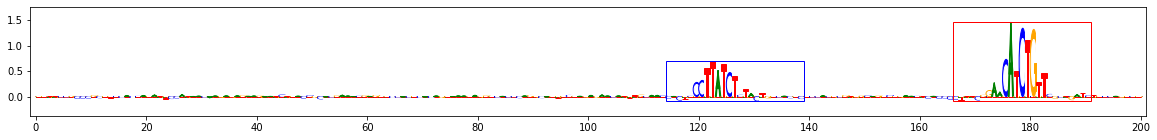

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=1.4567729, exampleidx=16, start=44, end=69, is_revcomp=False, seqlet_orig_start=38, seqlet_orig_end=63, seqlet_orig_revcomp=False, aggregate_sim=0.3431987516774697, mod_delta=0.0007508574969085947, mod_precision=1.0, mod_percentile=0.09859154929577463, fann_perclasssum_perc=0.14084507042253525, fann_perclassavg_perc=0.14084507042253525)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=2.2477548, exampleidx=16, start=92, end=117, is_revcomp=False, seqlet_orig_start=93, seqlet_orig_end=118, seqlet_orig_revcomp=False, aggregate_sim=0.47378934731244826, mod_delta=0.001105656555967849, mod_precision=1.0, mod_percentile=0.7183098591549295, fann_perclasssum_perc=0.45070422535211263, fann_perclassavg_perc=0.45070422535211263)


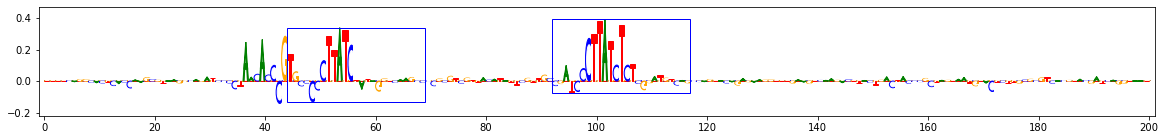

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=1.6707146, exampleidx=17, start=12, end=37, is_revcomp=True, seqlet_orig_start=11, seqlet_orig_end=36, seqlet_orig_revcomp=False, aggregate_sim=0.3728912959520213, mod_delta=0.000861347799474263, mod_precision=1.0, mod_percentile=0.19718309859154926, fann_perclasssum_perc=0.11267605633802813, fann_perclassavg_perc=0.11267605633802813)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=5.65648, exampleidx=17, start=55, end=80, is_revcomp=True, seqlet_orig_start=56, seqlet_orig_end=81, seqlet_orig_revcomp=False, aggregate_sim=0.4698634471819284, mod_delta=0.000984121788740265, mod_precision=1.0, mod_percentile=0.527027027027027, fann_perclasssum_perc=0.21621621621621623, fann_perclassavg_perc=0.21621621621621623)


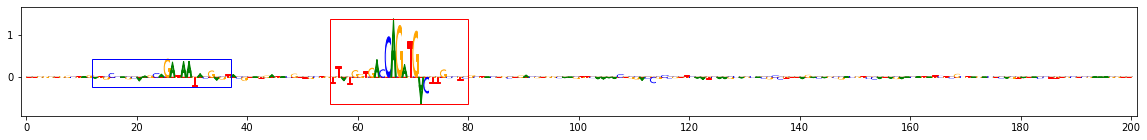

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=10.450417, exampleidx=18, start=104, end=129, is_revcomp=False, seqlet_orig_start=95, seqlet_orig_end=120, seqlet_orig_revcomp=False, aggregate_sim=0.6229585820921113, mod_delta=0.0006838008162439119, mod_precision=1.0, mod_percentile=0.05633802816901412, fann_perclasssum_perc=0.9436619718309859, fann_perclassavg_perc=0.9436619718309859)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=8.269183, exampleidx=18, start=116, end=141, is_revcomp=False, seqlet_orig_start=119, seqlet_orig_end=144, seqlet_orig_revcomp=False, aggregate_sim=0.5718526740769201, mod_delta=0.0009199322826839613, mod_precision=1.0, mod_percentile=0.33783783783783783, fann_perclasssum_perc=0.6756756756756757, fann_perclassavg_perc=0.6756756756756757)


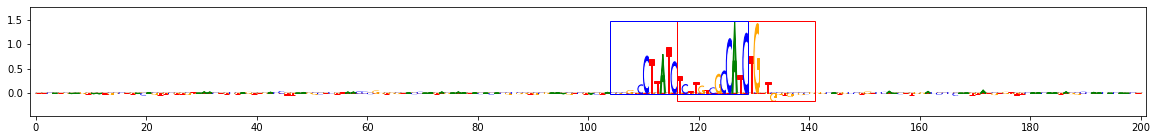

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=1.6857536, exampleidx=19, start=23, end=48, is_revcomp=False, seqlet_orig_start=17, seqlet_orig_end=42, seqlet_orig_revcomp=False, aggregate_sim=0.460940587556473, mod_delta=0.000978756466161441, mod_precision=1.0, mod_percentile=0.49295774647887325, fann_perclasssum_perc=0.5492957746478873, fann_perclassavg_perc=0.5492957746478873)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=3.231012, exampleidx=19, start=143, end=168, is_revcomp=False, seqlet_orig_start=147, seqlet_orig_end=172, seqlet_orig_revcomp=False, aggregate_sim=0.3379741850413466, mod_delta=0.0001318492635123212, mod_precision=1.0, mod_percentile=0.027027027027026973, fann_perclasssum_perc=0.04054054054054057, fann_perclassavg_perc=0.04054054054054057)


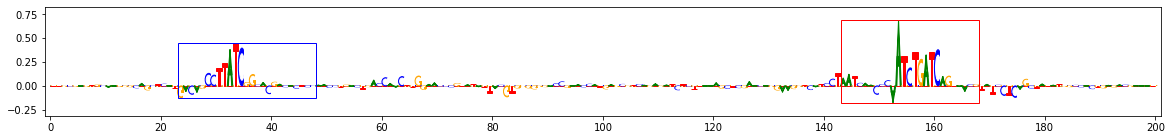

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=3.5842912, exampleidx=20, start=15, end=40, is_revcomp=True, seqlet_orig_start=13, seqlet_orig_end=38, seqlet_orig_revcomp=False, aggregate_sim=0.5739702633918188, mod_delta=0.0009408081645011831, mod_precision=1.0, mod_percentile=0.3661971830985915, fann_perclasssum_perc=0.9014084507042254, fann_perclassavg_perc=0.9014084507042254)


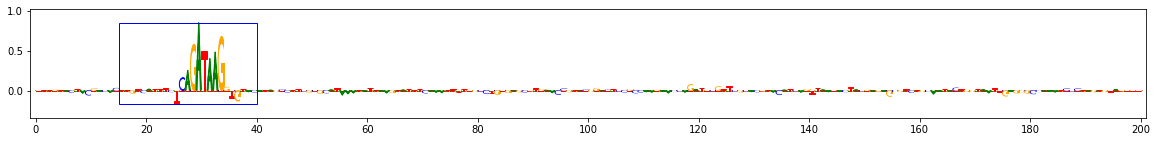

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=4.950571, exampleidx=21, start=15, end=40, is_revcomp=False, seqlet_orig_start=16, seqlet_orig_end=41, seqlet_orig_revcomp=False, aggregate_sim=0.5317910185243885, mod_delta=0.0010449295389570543, mod_precision=1.0, mod_percentile=0.6891891891891893, fann_perclasssum_perc=0.6216216216216216, fann_perclassavg_perc=0.6216216216216216)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=2.797364, exampleidx=21, start=56, end=81, is_revcomp=False, seqlet_orig_start=56, seqlet_orig_end=81, seqlet_orig_revcomp=False, aggregate_sim=0.5423599496626689, mod_delta=0.0010516959060352894, mod_precision=1.0, mod_percentile=0.6338028169014085, fann_perclasssum_perc=0.8028169014084507, fann_perclassavg_perc=0.8028169014084507)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=3.203272, exampleidx=21, start=92, end=117, is_revcomp=False, seqlet_orig_start=94, seqlet_orig_end=119, 

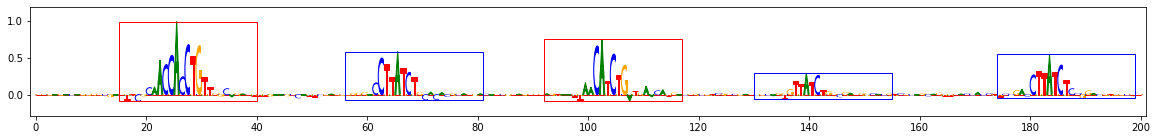

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=0.59491074, exampleidx=23, start=21, end=46, is_revcomp=True, seqlet_orig_start=21, seqlet_orig_end=46, seqlet_orig_revcomp=False, aggregate_sim=0.38767019893247334, mod_delta=0.0005121229711860529, mod_precision=1.0, mod_percentile=0.027027027027026973, fann_perclasssum_perc=0.05405405405405406, fann_perclassavg_perc=0.05405405405405406)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.5567217, exampleidx=23, start=104, end=129, is_revcomp=True, seqlet_orig_start=101, seqlet_orig_end=126, seqlet_orig_revcomp=False, aggregate_sim=0.498646073753514, mod_delta=0.0010224292646599693, mod_precision=1.0, mod_percentile=0.6486486486486487, fann_perclasssum_perc=0.43243243243243246, fann_perclassavg_perc=0.43243243243243246)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=2.5491796, exampleidx=23, start=121, end=146, is_revcomp=True, seqlet_orig_start=118, seqlet_o

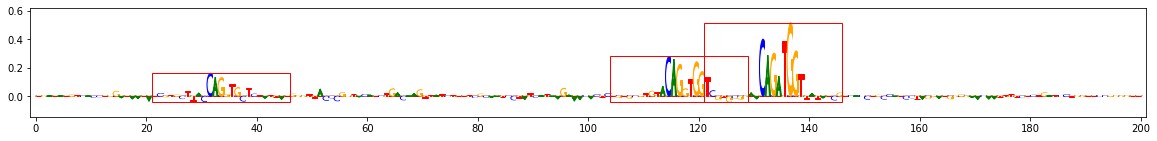

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=1.331819, exampleidx=24, start=35, end=60, is_revcomp=False, seqlet_orig_start=30, seqlet_orig_end=55, seqlet_orig_revcomp=False, aggregate_sim=0.45063261197775334, mod_delta=0.0009055943914552268, mod_precision=1.0, mod_percentile=0.2816901408450704, fann_perclasssum_perc=0.47887323943661975, fann_perclassavg_perc=0.47887323943661975)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=1.4840351, exampleidx=24, start=127, end=152, is_revcomp=False, seqlet_orig_start=121, seqlet_orig_end=146, seqlet_orig_revcomp=False, aggregate_sim=0.47329087893014393, mod_delta=0.0009171783893180373, mod_precision=1.0, mod_percentile=0.3098591549295775, fann_perclasssum_perc=0.5352112676056338, fann_perclassavg_perc=0.5352112676056338)


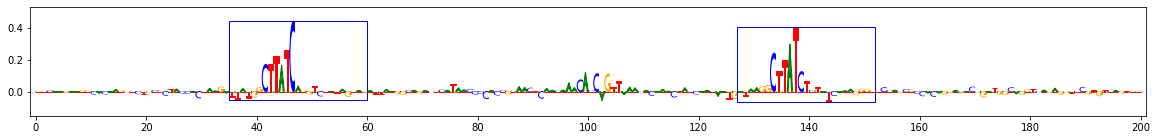

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.3993547, exampleidx=25, start=12, end=37, is_revcomp=False, seqlet_orig_start=9, seqlet_orig_end=34, seqlet_orig_revcomp=False, aggregate_sim=0.44686177465090127, mod_delta=0.0005168706877813007, mod_precision=1.0, mod_percentile=0.027027027027026973, fann_perclasssum_perc=0.22972972972972971, fann_perclassavg_perc=0.22972972972972971)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=2.666249, exampleidx=25, start=62, end=87, is_revcomp=False, seqlet_orig_start=64, seqlet_orig_end=89, seqlet_orig_revcomp=False, aggregate_sim=0.6013524526472745, mod_delta=0.0010528459582197147, mod_precision=1.0, mod_percentile=0.7432432432432432, fann_perclasssum_perc=0.8648648648648649, fann_perclassavg_perc=0.8648648648648649)
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=-1.1229897, exampleidx=25, start=86, end=111, is_revcomp=True, seqlet_orig_start=91, seqlet_orig_end

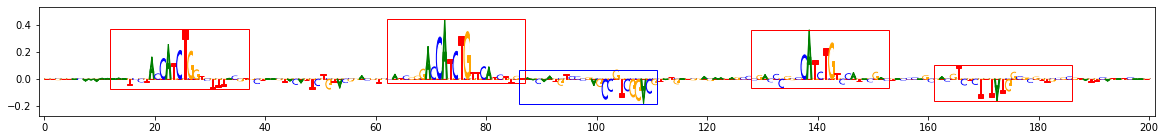

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=-0.8175413, exampleidx=26, start=32, end=57, is_revcomp=True, seqlet_orig_start=36, seqlet_orig_end=61, seqlet_orig_revcomp=False, aggregate_sim=0.09159877342703752, mod_delta=0.00017609534832831522, mod_precision=1.0, mod_percentile=0.027027027027026973, fann_perclasssum_perc=0.0, fann_perclassavg_perc=0.0)


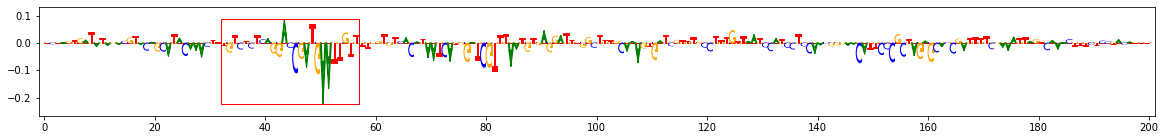

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.70914465, exampleidx=27, start=61, end=86, is_revcomp=False, seqlet_orig_start=56, seqlet_orig_end=81, seqlet_orig_revcomp=False, aggregate_sim=0.2974012308269414, mod_delta=0.0011459387829874613, mod_precision=1.0, mod_percentile=0.8591549295774648, fann_perclasssum_perc=0.05633802816901412, fann_perclassavg_perc=0.05633802816901412)


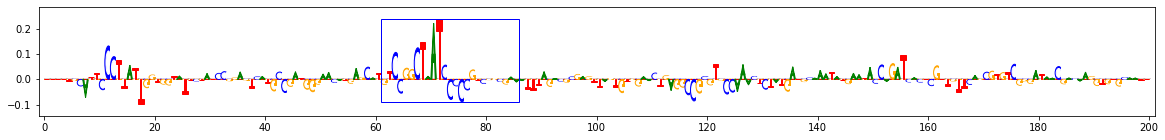

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.8963196, exampleidx=28, start=12, end=37, is_revcomp=True, seqlet_orig_start=9, seqlet_orig_end=34, seqlet_orig_revcomp=False, aggregate_sim=0.531609151274179, mod_delta=0.00048328991669555933, mod_precision=1.0, mod_percentile=0.027027027027026973, fann_perclasssum_perc=0.4864864864864865, fann_perclassavg_perc=0.4864864864864865)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=2.7144322, exampleidx=28, start=150, end=175, is_revcomp=True, seqlet_orig_start=147, seqlet_orig_end=172, seqlet_orig_revcomp=False, aggregate_sim=0.5463504103720993, mod_delta=0.0007741657666074644, mod_precision=1.0, mod_percentile=0.1216216216216216, fann_perclasssum_perc=0.7432432432432432, fann_perclassavg_perc=0.7432432432432432)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=0.99053746, exampleidx=28, start=177, end=202, is_revcomp=True, seqlet_orig_start=174, seqlet_orig_e

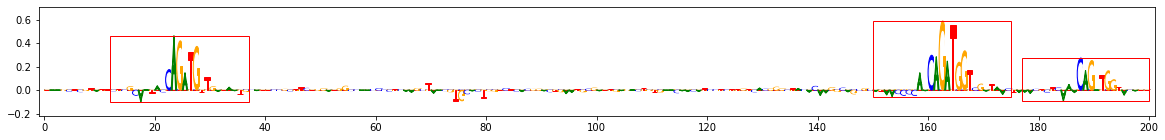

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=3.5855014, exampleidx=29, start=57, end=82, is_revcomp=False, seqlet_orig_start=58, seqlet_orig_end=83, seqlet_orig_revcomp=False, aggregate_sim=0.44827230449112304, mod_delta=0.0012069600000308165, mod_precision=1.0, mod_percentile=0.971830985915493, fann_perclasssum_perc=0.3661971830985915, fann_perclassavg_perc=0.3661971830985915)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=6.5478487, exampleidx=29, start=160, end=185, is_revcomp=False, seqlet_orig_start=162, seqlet_orig_end=187, seqlet_orig_revcomp=False, aggregate_sim=0.564110953759458, mod_delta=0.0011040119830777332, mod_precision=1.0, mod_percentile=0.8648648648648649, fann_perclasssum_perc=0.5945945945945945, fann_perclassavg_perc=0.5945945945945945)


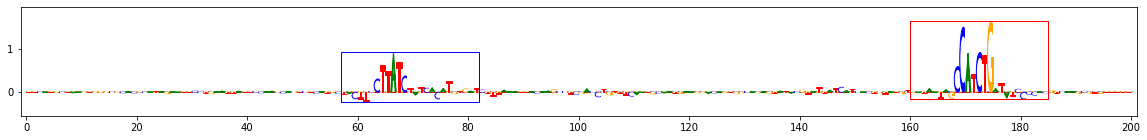

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=3.9292576, exampleidx=30, start=65, end=90, is_revcomp=False, seqlet_orig_start=70, seqlet_orig_end=95, seqlet_orig_revcomp=False, aggregate_sim=0.42532418854456394, mod_delta=0.0006659666346651811, mod_precision=1.0, mod_percentile=0.05405405405405406, fann_perclasssum_perc=0.1216216216216216, fann_perclassavg_perc=0.1216216216216216)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=2.353835, exampleidx=30, start=81, end=106, is_revcomp=False, seqlet_orig_start=80, seqlet_orig_end=105, seqlet_orig_revcomp=False, aggregate_sim=0.15272878306741866, mod_delta=1.9682871476288735e-05, mod_precision=0.8812154189969473, mod_percentile=0.0, fann_perclasssum_perc=0.0, fann_perclassavg_perc=0.0)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=-0.47952798, exampleidx=30, start=110, end=135, is_revcomp=False, seqlet_orig_start=106, seqlet_orig_end=131, seqlet_orig_revcom

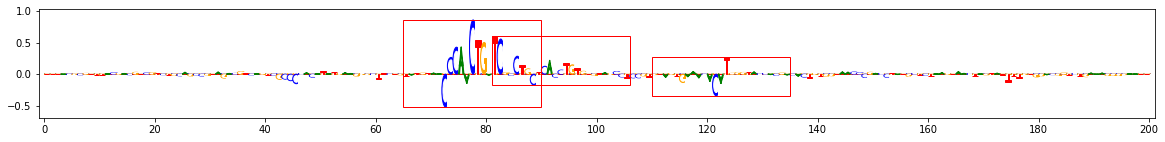

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=5.0034137, exampleidx=31, start=14, end=39, is_revcomp=True, seqlet_orig_start=17, seqlet_orig_end=42, seqlet_orig_revcomp=False, aggregate_sim=0.6287055797793255, mod_delta=0.0009577468143028697, mod_precision=1.0, mod_percentile=0.44594594594594594, fann_perclasssum_perc=0.9594594594594594, fann_perclassavg_perc=0.9594594594594594)
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.2678905, exampleidx=31, start=133, end=158, is_revcomp=True, seqlet_orig_start=129, seqlet_orig_end=154, seqlet_orig_revcomp=False, aggregate_sim=0.47425768844290517, mod_delta=0.0009373222478048825, mod_precision=1.0, mod_percentile=0.3648648648648649, fann_perclasssum_perc=0.29729729729729726, fann_perclassavg_perc=0.29729729729729726)


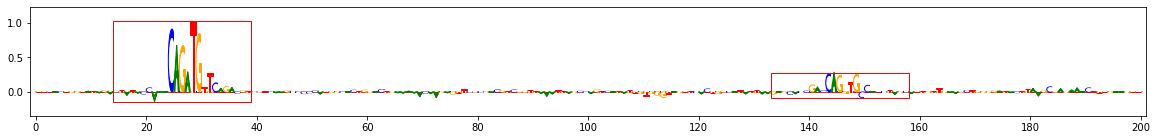

In [10]:
from modisco.visualization import viz_sequence

#visualize the matches
for exampleidx in list(sorted(exampleidx_to_matches.keys()))[:30]:
    matches = exampleidx_to_matches[exampleidx]
    for match in matches:
        print(match)
    
    viz_sequence.plot_weights(
        task_to_scores["task0"][exampleidx],
        highlight={'red': [
            (max(x.start,0), min(x.end,len(task_to_scores["task0"][exampleidx])))
             for x in matches if x.patternidx==0],
                   'blue': [
            (max(x.start,0), min(x.end,len(task_to_scores["task0"][exampleidx])) )
             for x in matches if x.patternidx==1]},
        subticks_frequency=20)

## Inspect the pattern merging hierarchy

Inspect the hierarchy of motif merging events that led to the final motif. Read "Path to node" like a directory structure; all motifs at a similar level in the hierarchy (except for the topmost level) were collapsed together. Any motifs at the topmost level for which the number of seqlets was less than `final_min_cluster_size` were disbanded, and their seqlets were reassigned to the dominant motifs (provided the similarity passed a threshold)

For metacluster 0
Path to node: root/0
Number of seqlets 74


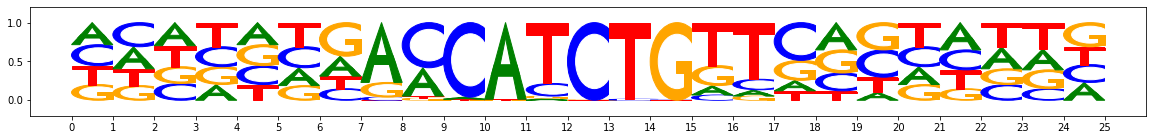

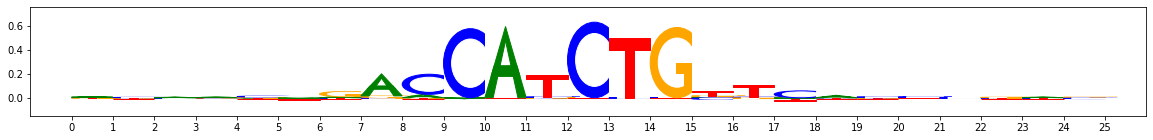

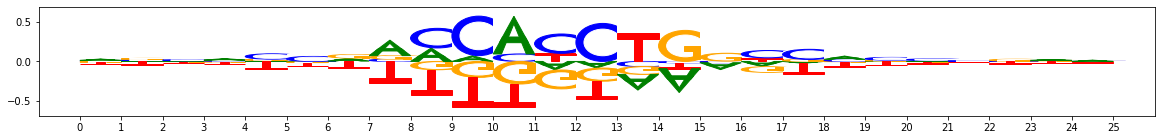

Path to node: root/1
Number of seqlets 71


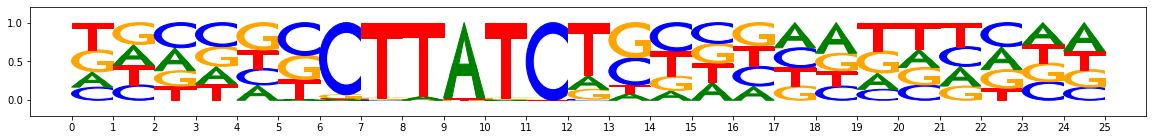

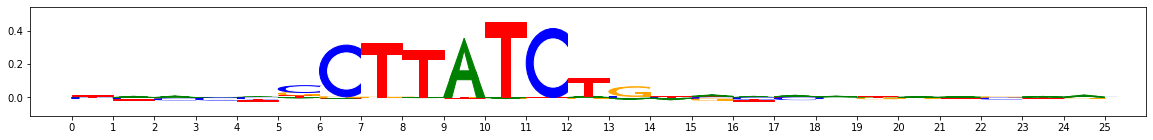

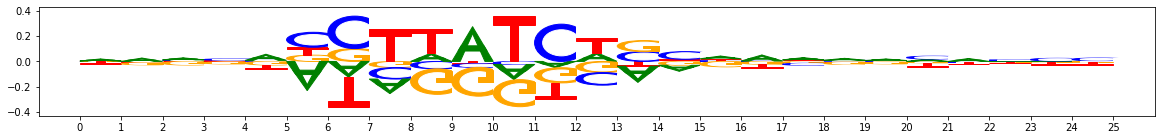

Path to node: root/2
Number of seqlets 3


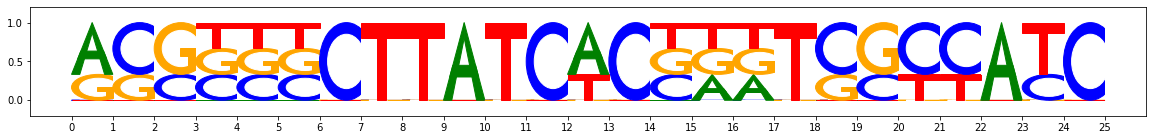

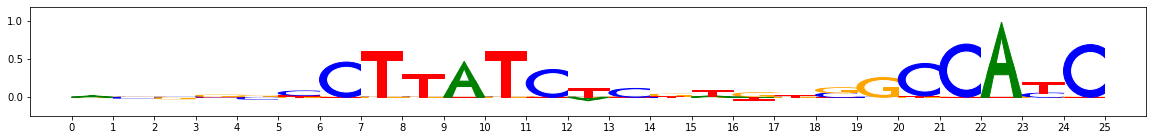

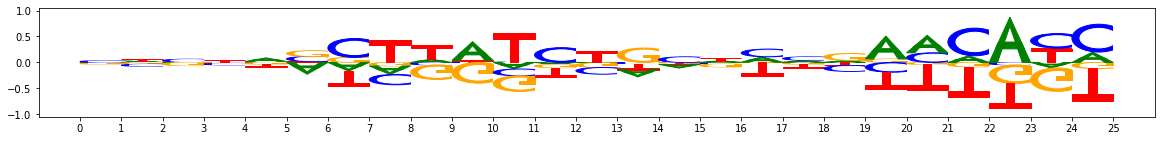

In [11]:
def recursive_plot_hierarchy_motifs(nodes, path):
    for i in range(len(nodes)):
        nodepath = path+"/"+str(i)
        print("Path to node:",nodepath)
        print("Number of seqlets",len(nodes[i].pattern.seqlets))
        if (nodes[i].indices_merged is not None):
            #indices_merged, submat_crosscontam and submat_alignersim can
            # be used to inspect the steps in the merging
            #print("indices merged:",nodes[i].indices_merged)
            #print("submat crosscontam:\n",nodes[i].submat_crosscontam)
            #print("submat alignersim:\n",nodes[i].submat_alignersim)
            pass
        
        #For plotting figures to a png, this code can be used...
        #fig = plt.figure(figsize=(20,5))                                           
        #ax = fig.add_subplot(111)
        #viz_sequence.plot_weights_given_ax(ax, nodes[i].pattern["sequence"].fwd)
        #plt.savefig(nodepath+".png")
        
        viz_sequence.plot_weights(nodes[i].pattern["sequence"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_hypothetical_contribs"].fwd)
        recursive_plot_hierarchy_motifs(nodes[i].child_nodes, path=nodepath)

print("For metacluster 0")
recursive_plot_hierarchy_motifs(loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.pattern_merge_hierarchy.root_nodes,
    path="root")